In [9]:
using Images
using Statistics
using Plots
using DSP
using StatsBase
using VectorizedStatistics
using ImageMorphology
using StatsPlots

In [1]:
function mask_site(file; threshold=0.5, n_sites=1)
    img = load(file)
    im_array = Float64.(img) * 65535 # concert to 16bit
    # Don't do frame averaging. Was found not neccessary for images used. 
    # Use stack standard dev projection to find polarity patch(es)
    img_std = std(im_array, dims=(3))[:,:,1]
    max_bin = 0
    bin = img_std .> maximum(img_std)*threshold
    bin = dilate(bin, r=1)
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin         
        max_loc = findmax(bin.*img_std)[2]          # mask the image. find the max. get the coords.
        max_lab = bin_lab[max_loc]                  # get label in labeled mask from coords
        max_bin = bin_lab .== max_lab               # Make binary mask only around correct component
        im_masked = im_array .* max_bin 
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

In [2]:
# Modified for mutli-signal to return times instead of time-crops
# Smooth signal for finding half-max time to exclude noisy peaks
function crop_times(signal; frames=15*(60/5), thresh=0.5)
    signal=signal.-minimum(signal)
    smoothed = (signal[1:end-2] + signal[2:end-1] + signal[3:end]) / 3
    start = Integer(findall(smoothed .> ((maximum(signal))*thresh))[1])
    if start + frames < length(signal)
        times = start:start+Integer(frames)
        return times
    else 
        last = length(signal)
        times = last-Integer(frames):last
        print(".")
        return times
    end
end

crop_times (generic function with 1 method)

In [19]:
function get_signal(file; interval=5, n_sites=1)
    masks = mask_site(file, n_sites=n_sites);
    im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
    mask = masks[:,:,:,1]
    signal = maximum(mask, dims=(1,2))[1,1,:]
    times_max = crop_times(signal, frames=15*(60/interval))
    crop = signal[times_max]
    return crop
end

get_signal (generic function with 1 method)

In [180]:
function plot_trace(signal; interval=5)
    t = range(0,60/interval*15)*(interval/60) # Convert from 1 frame every 5 sec, to minutes
    plot!(t, signal, xticks=range(0,15), linewidth=2, label=false, dpi=600,
        xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm)
end

plot_trace (generic function with 2 methods)

In [229]:
function get_powers(signal; interval=15)
    pdg = DSP.Periodograms.periodogram(signal)
    powers = pdg.power
    frequencies = pdg.freq
    periods = 1 ./ frequencies
    return periods, powers
end

get_powers (generic function with 1 method)

In [226]:
function plot_pdg(signal; interval=5)
    pdg_max = DSP.Periodograms.periodogram(signal)
    max_powers = pdg_max.power
    frequencies = pdg_max.freq
    print(1 / frequencies[4+findmax(max_powers[4:end])[2]] * (interval/60))
    plot!(1 ./ frequencies[4:end] .* (interval/60), max_powers[4:end], xflip = false, label=false, dpi=600,
        linewidth=2, alpha=0.5, size=(400,200), margin=5Plots.mm)
end

plot_pdg (generic function with 1 method)

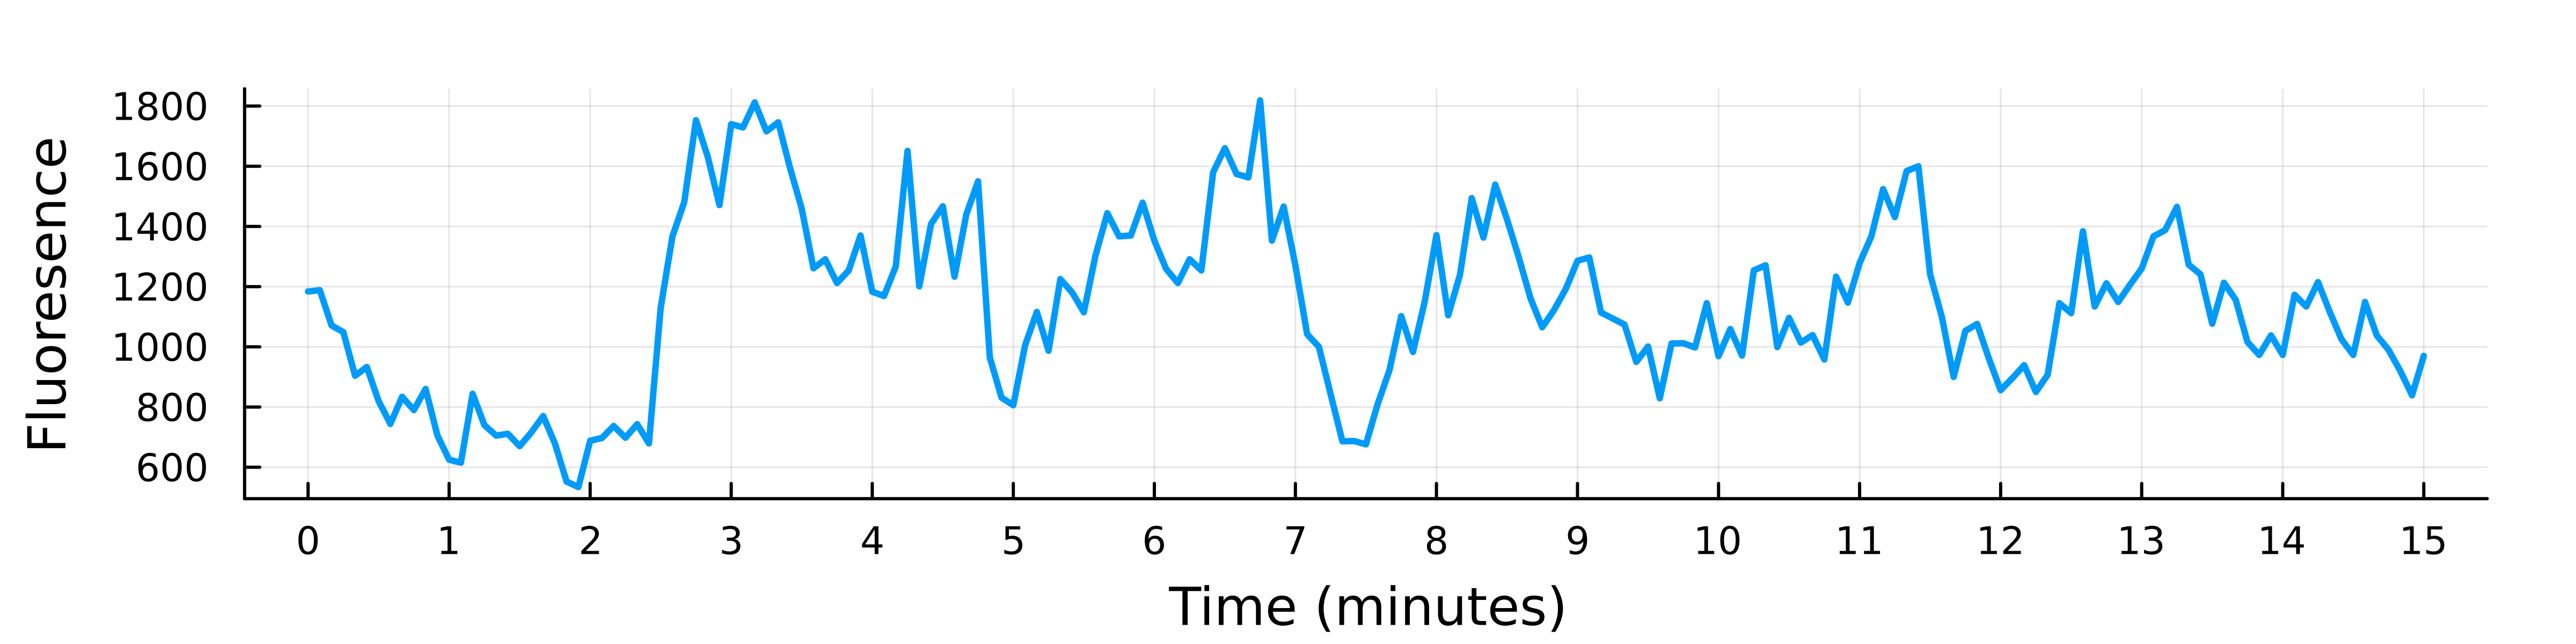

In [213]:
file = "../data/2024_10_10-3XGBwt/crops/movie3-cell19.tif"
#file = "../data/movies-rga-bem3-cdc42/bem3/cell1.tif"
signal = get_signal(file, interval=5);
plot()
plot_trace(signal, interval=5)

2.25

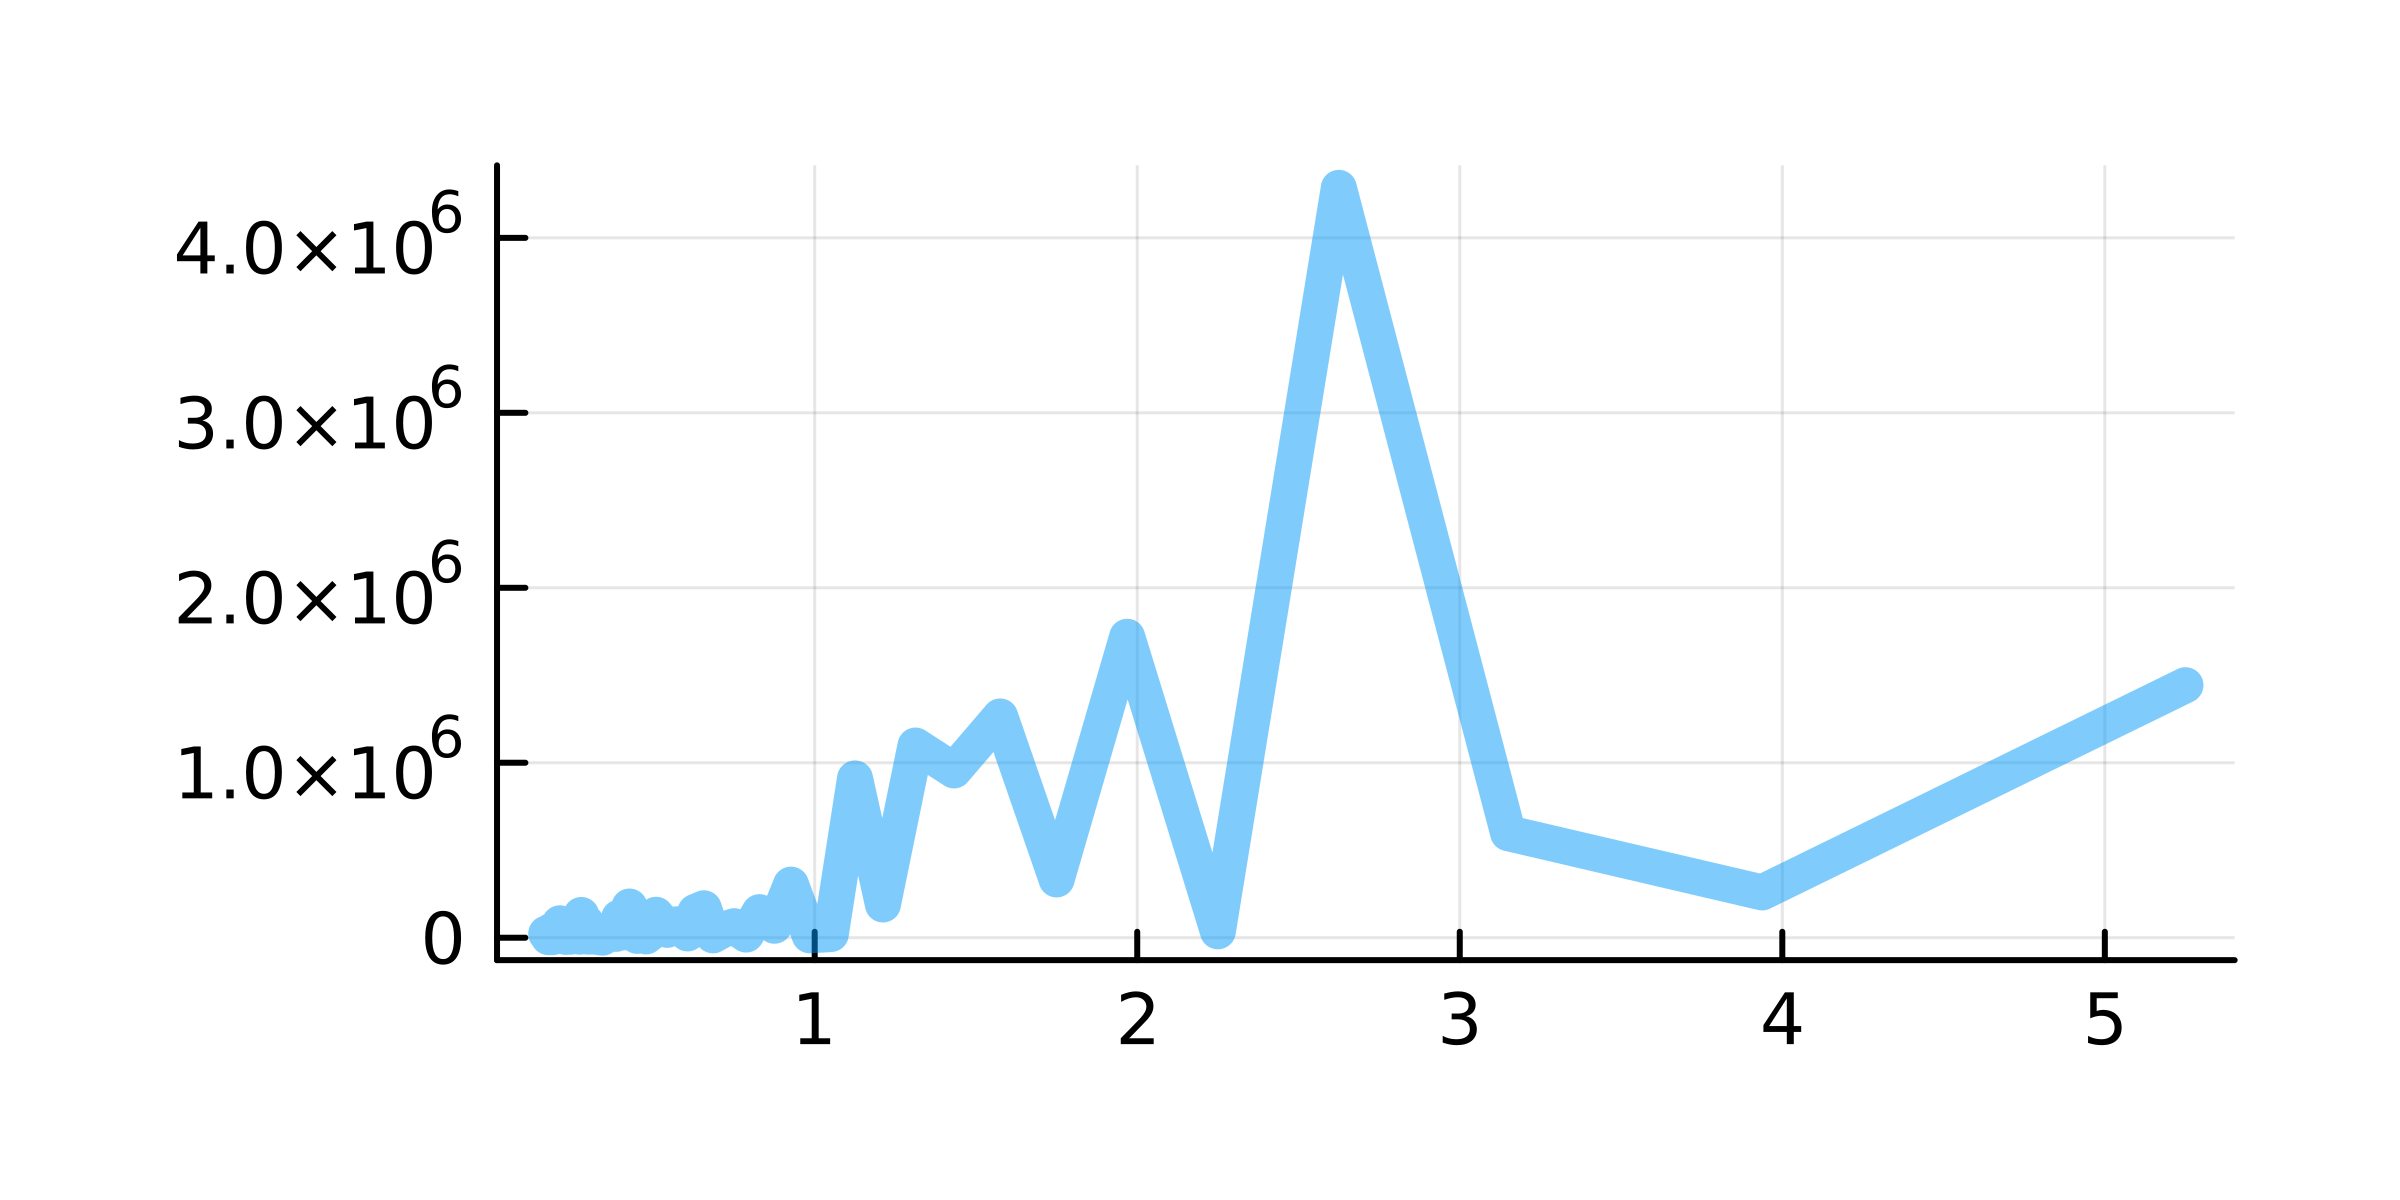

In [214]:
plot()
print(findmax(signal))
plot_pdg(signal, interval=5)

.1.31253.9375.2.25.1.968752.625.3.93753.93752.251.752.252.253.1500000000000004.3.15000000000000041.753.93753.15000000000000041.751.57500000000000023.93753.93751.43181818181818193.93753.93751.968752.6251.3125

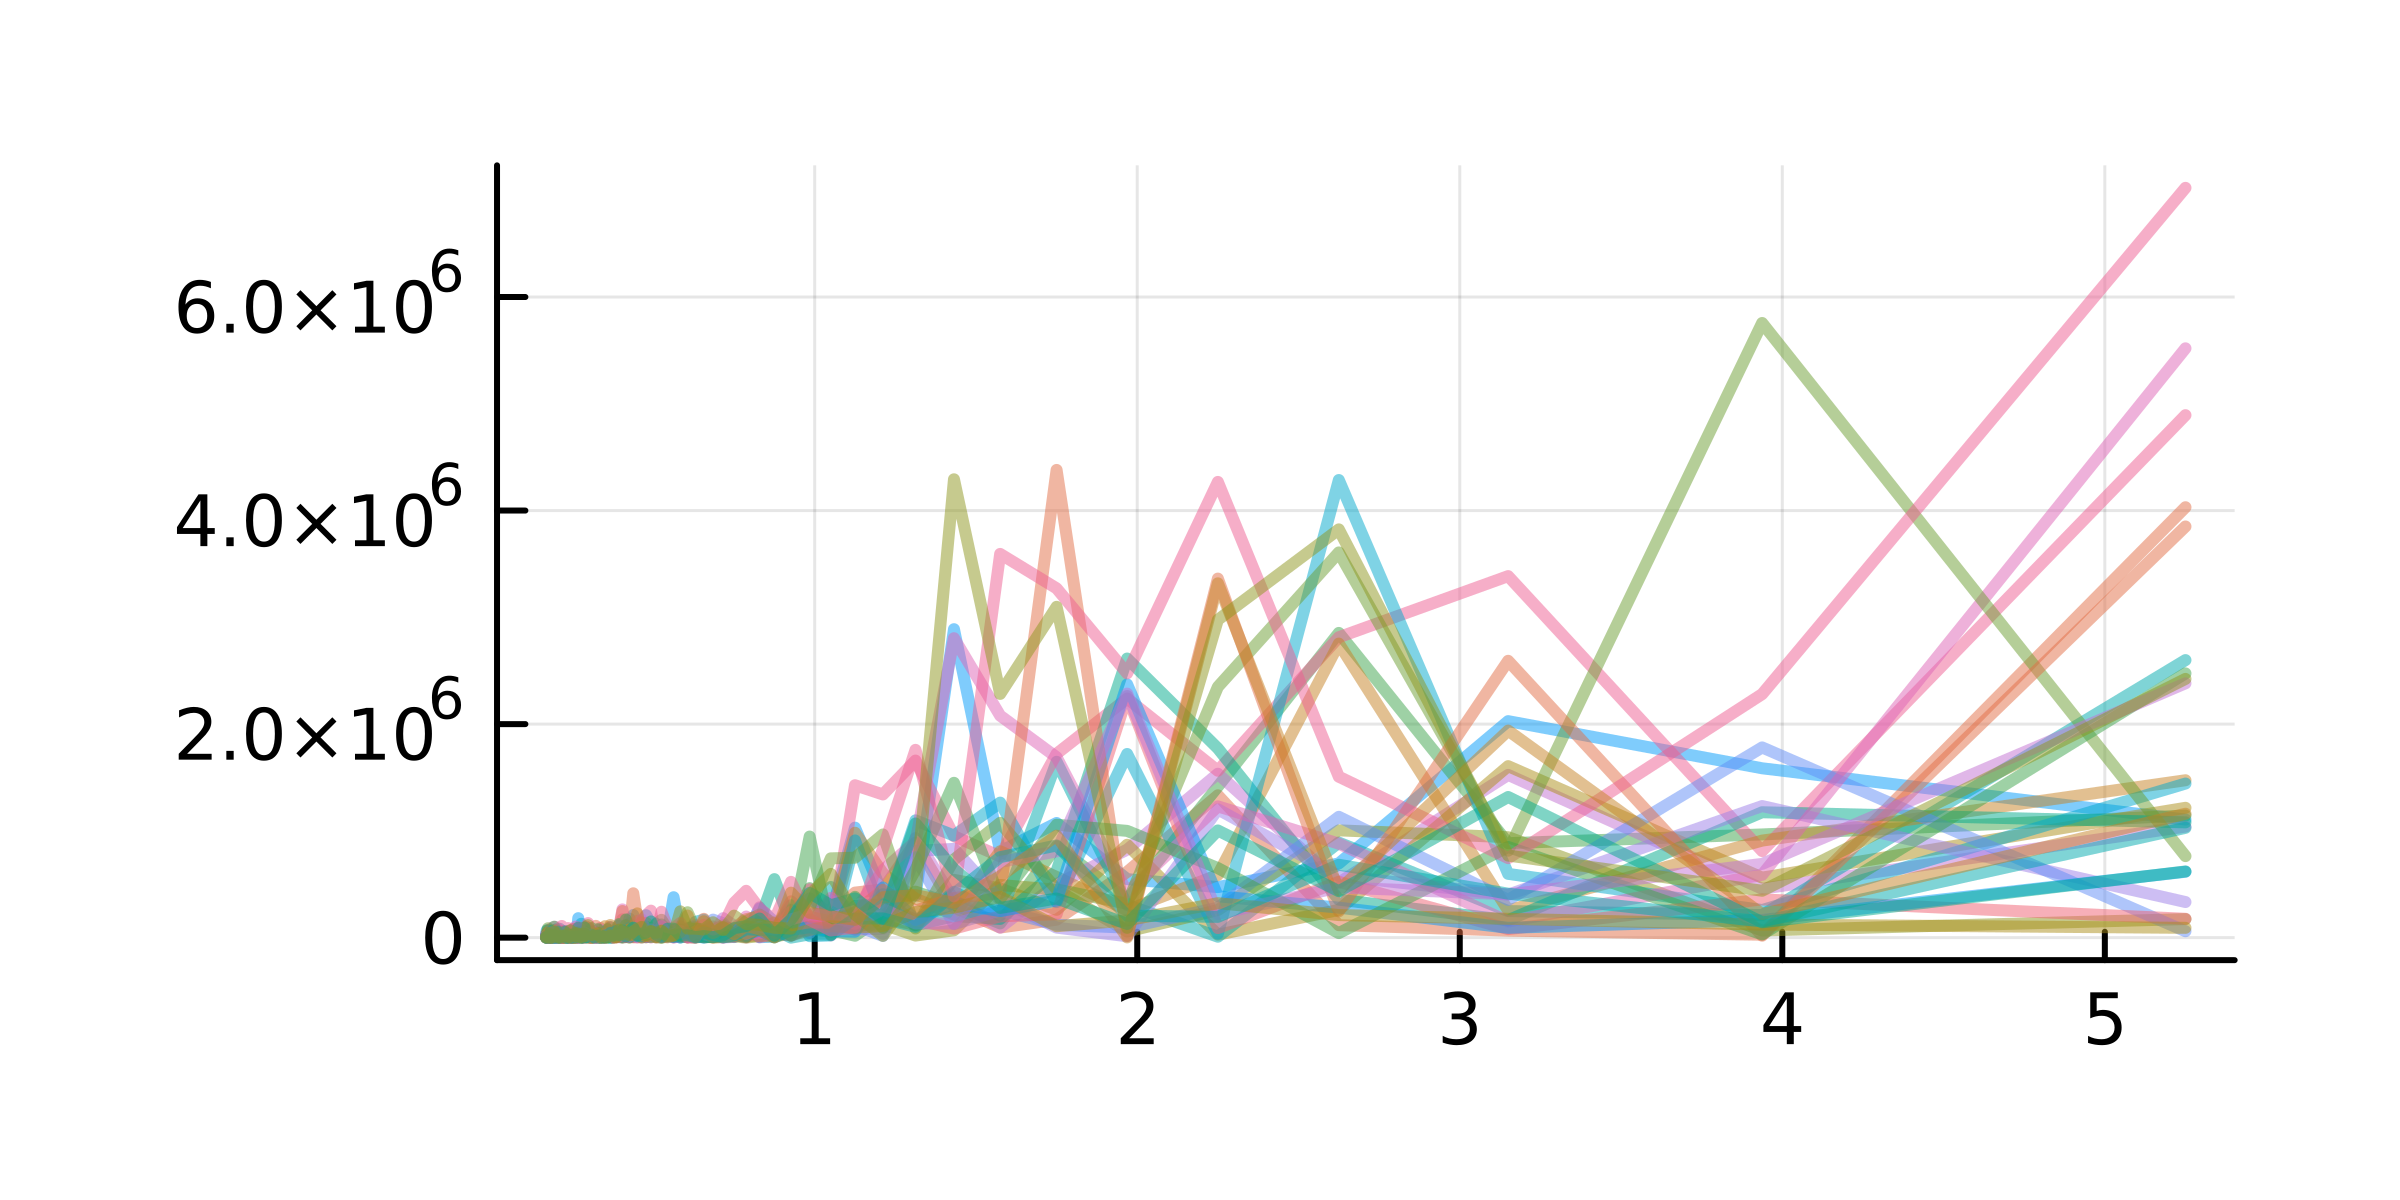

In [227]:
dir = "../data/2024_10_10-3XGBwt/crops/"
wt_files = readdir(dir)
plot()
for f in wt_files
    signal = get_signal("$dir$f", interval=5)
    plot_pdg(signal, interval=5)
end
plot!()